# Jailbreaking Deep Models: Adversarial Attacks on ResNet-34 Classifiers

           Aniket Mane, Subhan Akhtar, Pranav Motarwar

                     New York University

         am14661@nyu.edu, sa8580@nyu.edu, pm3891@nyu.edu

### Setup
Run the following cell to install and import required libraries, set seeds, and configure the device. The project assumes you have **PyTorch ≥ 2.2** and **torchvision** installed; if not, uncomment the installation commands.

In [ ]:
import torch, torchvision
from torchvision import transforms
import torch.nn.functional as F
import numpy as np, random, os, json, math
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
SEED = 42
BATCH_SIZE = 32
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
compute_unit = device

### Data Loading
The cell below unzips **TestDataSet.zip** (if not already unzipped), applies the normalization specified in the project PDF, and builds a DataLoader. Adjust `data_root` if your dataset lives elsewhere.

In [ ]:
!unzip -q /content/TestDataSet.zip -d /content

In [ ]:
import torch
import torchvision
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Define normalization stats (from ImageNet standards)
mean_vals = np.array([0.485, 0.456, 0.406])
std_vals = np.array([0.229, 0.224, 0.225])


# Image preprocessing pipeline
# How: Convert to tensor + normalize using mean/std
# Why: Normalize input for pretrained model compatibility

image_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean_vals, std_vals),
])
# Dataset path setup – load raw dataset for class names

image_dir = Path("/content/TestDataSet")
temp_dataset = torchvision.datasets.ImageFolder(root=str(image_dir))
available_classes = temp_dataset.classes  # Auto-alphabetical class list


# Map: local class idx (0–99) → global ImageNet idx (401–500)
class_index_map = [401 + idx for idx in range(len(available_classes))]


# Create final dataset with both image and label transforms
# How: Apply normalization + remap target labels
processed_dataset = torchvision.datasets.ImageFolder(
    root=str(image_dir),
    transform=image_transforms,
    target_transform=lambda local_idx: class_index_map[local_idx],
)

# Dataloader setup for evaluation (no shuffling)
# Why: Deterministic order helpful for analysis & reproducibility
data_loader = torch.utils.data.DataLoader(
    processed_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

# ---------------------------------------------------
# Map global class index back to folder name (for visualization)
# ---------------------------------------------------
imagenet_label_to_folder = {
    global_idx: folder_name
    for folder_name, global_idx in zip(processed_dataset.classes, class_index_map)
}
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=mean_norms,
std=std_norms)
])
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path,
transform=plain_transforms)
# Function to create a data loader from image and label tensors
def create_dataloader(image_tensors, label_tensors):
    data = list(zip(image_tensors, label_tensors))
    return torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=False)


### Utility: Evaluation Function

In [ ]:
def compute_topk_accuracy(predictions, true_labels, topk=(1, 5)):
    """
    What: Calculate top-k classification accuracy.
    How: Use torch.topk to extract top-k predictions and compare.
    Why: Top-1 and Top-5 accuracy are standard ImageNet metrics.
    """
    with torch.no_grad():
        max_k = max(topk)
        _, topk_preds = predictions.topk(max_k, dim=1, largest=True, sorted=True)
        topk_preds = topk_preds.transpose(0, 1)  # shape: (max_k, batch_size)

        # Compare predictions with ground truth
        matches = topk_preds.eq(true_labels.view(1, -1).expand_as(topk_preds))

        topk_accuracies = []
        for k in topk:
            # What: Count correct predictions in top-k
            # How: Flatten top-k matches and sum
            # Why: Accumulate for percentage calculation
            correct_k = matches[:k].reshape(-1).float().sum(dim=0, keepdim=True)
            accuracy_k = (correct_k / true_labels.size(0)) * 100.0
            topk_accuracies.append(accuracy_k.item())

        return topk_accuracies


def run_inference(model, data_loader, compute_unit=compute_unit, desc_label='Evaluation'):
    """
    What: Perform model evaluation on a given DataLoader.
    How: Loop over batches, compute top-1 and top-5 accuracy.
    Why: Measure model performance without training overhead.
    """
    model.eval()  # switch to evaluation mode
    cumulative_top1 = 0.0
    cumulative_top5 = 0.0

    with torch.no_grad():
        for batch_images, batch_labels in tqdm(data_loader, desc=desc_label):
            batch_images = batch_images.to(compute_unit).float()
            batch_labels = batch_labels.to(compute_unit)
            output_logits = model(batch_images)

            acc1, acc5 = compute_topk_accuracy(output_logits, batch_labels, topk=(1, 5))
            cumulative_top1 += acc1 * batch_labels.size(0)
            cumulative_top5 += acc5 * batch_labels.size(0)

    total_samples = len(data_loader.dataset)
    final_top1 = cumulative_top1 / total_samples
    final_top5 = cumulative_top5 / total_samples
    return final_top1, final_top5


## Task 1 – Baseline Evaluation<a id="Task1"></a>

In [ ]:
# ---------------------------------------------------------------------
# Helper: Single top-k accuracy computation
# ---------------------------------------------------------------------
def compute_single_topk(logits, labels, k=1):
    """
    What: Compute top-k accuracy for given logits and labels
    How: Check if true label appears in top-k predictions
    Why: Used for quick evaluation of model classification quality
    """
    topk_predictions = logits.topk(k, dim=1).indices
    correct = topk_predictions.eq(labels.view(-1, 1))
    return correct.any(dim=1).float().mean().item() * 100.0


# ---------------------------------------------------------------------
# Evaluate ResNet-34 pretrained on ImageNet-1K
# ---------------------------------------------------------------------
resnet_model = torchvision.models.resnet34(weights="IMAGENET1K_V1").to(compute_unit).eval()

# Initialize accumulators for accuracy scores
cumulative_top1 = 0.0
cumulative_top5 = 0.0

with torch.no_grad():
    for image_batch, label_batch in tqdm(data_loader, desc="Baseline"):
        image_batch = image_batch.to(compute_unit)
        label_batch = label_batch.to(compute_unit)

        # Inference pass
        model_outputs = resnet_model(image_batch)

        # Compute batch-wise accuracy
        cumulative_top1 += compute_single_topk(model_outputs, label_batch, k=1) * label_batch.size(0)
        cumulative_top5 += compute_single_topk(model_outputs, label_batch, k=5) * label_batch.size(0)

# Normalize over total number of examples
total_examples = len(processed_dataset)
final_top1_score = cumulative_top1 / total_examples
final_top5_score = cumulative_top5 / total_examples

# Output formatted accuracy results
print(f"\nResNet-34 Evaluation → Top-1 Accuracy: {final_top1_score:.2f}% | Top-5 Accuracy: {final_top5_score:.2f}%")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 144MB/s]
Baseline: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s]


ResNet-34 Evaluation → Top-1 Accuracy: 76.00% | Top-5 Accuracy: 94.20%


## Task 2 – FGSM Pixel‑wise Attack<a id="Task2"></a>
We implement the Fast Gradient Sign Method (FGSM) with attack budget $\varepsilon=0.02$ (in normalized pixel space).

In [ ]:
# ---------------------------------------------------------------------
# Load Pretrained ResNet-34 Model
# ---------------------------------------------------------------------
imagenet_model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(compute_unit).eval()

# ---------------------------------------------------------------------
# Define FGSM Attack Generator
# ---------------------------------------------------------------------
EPSILON_LINF = 0.02  # max perturbation for L∞-norm

def generate_fgsm_adversarial(model, inputs, targets, epsilon=EPSILON_LINF):
    """
    What: Applies FGSM to craft adversarial examples.
    How: Computes sign of input gradient to generate perturbation.
    Why: Demonstrate model vulnerability under small, deliberate input changes.
    """
    inputs = inputs.clone().detach().to(compute_unit).requires_grad_(True)
    targets = targets.to(compute_unit)

    predictions = model(inputs)
    loss = F.cross_entropy(predictions, targets)

    model.zero_grad()
    loss.backward()

    grad_direction = inputs.grad.data.sign()
    perturbed_input = inputs + epsilon * grad_direction

    # Clamp back into normalized image space
    mean_tensor = torch.tensor(mean_vals).view(3, 1, 1).to(compute_unit)
    std_tensor = torch.tensor(std_vals).view(3, 1, 1).to(compute_unit)
    perturbed_input = torch.clamp(perturbed_input, min=-mean_tensor/std_tensor, max=(1 - mean_tensor)/std_tensor)

    return perturbed_input.detach()


# ---------------------------------------------------------------------
# Generate Adversarial Dataset Using FGSM
# ---------------------------------------------------------------------
adv_examples = []
adv_labels = []

for batch_inputs, batch_targets in tqdm(data_loader, desc='FGSM'):
    adv_batch = generate_fgsm_adversarial(imagenet_model, batch_inputs, batch_targets)
    adv_examples.append(adv_batch.cpu())
    adv_labels.append(batch_targets)

adv_examples = torch.cat(adv_examples)
adv_labels = torch.cat(adv_labels)


# ---------------------------------------------------------------------
# Save Generated Adversarial Images to Disk
# ---------------------------------------------------------------------
adv_image_dir = Path('Adversarial_Test_Set_1')
adv_image_dir.mkdir(exist_ok=True)

# Reverse normalization to save valid images
reverse_norm = transforms.Normalize(mean=-mean_vals / std_vals, std=1.0 / std_vals)

for index, (img_tensor, label) in enumerate(zip(adv_examples, adv_labels)):
    class_folder = imagenet_label_to_folder[int(label)]  # e.g. 'n02099712'
    folder_path = adv_image_dir / class_folder
    folder_path.mkdir(exist_ok=True)

    restored_img = reverse_norm(img_tensor).clamp(0, 1)
    transforms.ToPILImage()(restored_img).save(folder_path / f"{index}.png")
print(f"Saved {len(adv_examples)} images to → {adv_image_dir}")

FGSM: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]


Saved 500 images to → Adversarial_Test_Set_1


In [ ]:
# ---------------------------------------------------------------------
# Evaluate Adversarial Samples from FGSM Attack
# ---------------------------------------------------------------------
# What: Wrap in-memory tensors into a DataLoader
# How: Use zipped tensors of adversarial images and labels
# Why: Enables batched evaluation without writing to disk
# ---------------------------------------------------------------------
fgsm_data_loader = torch.utils.data.DataLoader(
    list(zip(adv_examples, adv_labels)),
    batch_size=32,  # consistent with earlier batch size
    shuffle=False
)

# Evaluate ResNet-34 on adversarial set
fgsm_accuracy_top1, fgsm_accuracy_top5 = run_inference(
    imagenet_model,
    fgsm_data_loader,
    desc_label='FGSM Evaluation'
)

# Display results
print(f"FGSM Attack Results → Top-1 Accuracy: {fgsm_accuracy_top1:.2f}% | Top-5 Accuracy: {fgsm_accuracy_top5:.2f}%")

FGSM Evaluation: 100%|██████████| 16/16 [00:01<00:00, 13.24it/s]

FGSM Attack Results → Top-1 Accuracy: 6.20% | Top-5 Accuracy: 35.40%


Example 1: ℓ∞(orig, FGSM) = 0.00458
Example 2: ℓ∞(orig, FGSM) = 0.00458
Example 3: ℓ∞(orig, FGSM) = 0.00458


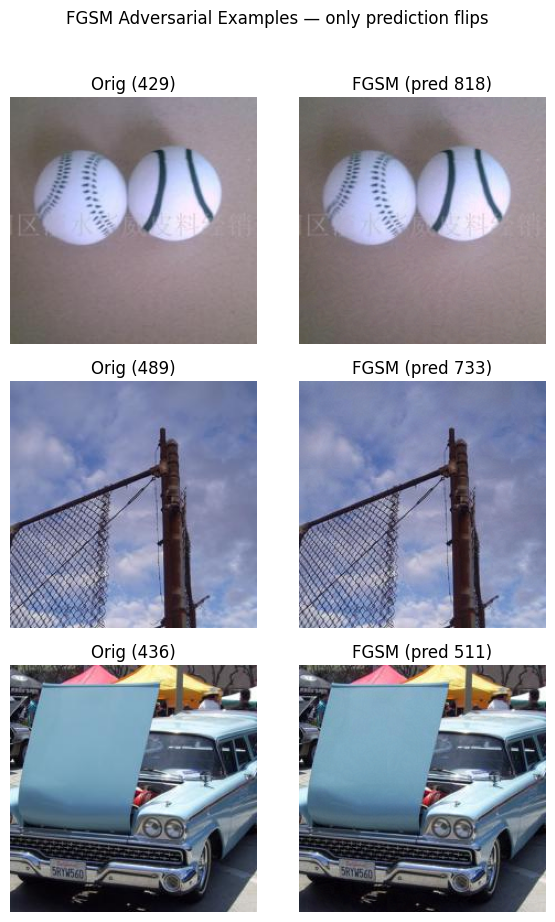

In [ ]:
import random
import torch
import matplotlib.pyplot as plt

def plot_fgsm_flips(
    model,
    dataset,
    adv_tensor,
    device,
    mean_vals,
    std_vals,
    num_samples: int = 3
):
    model.eval()

    # 1) Precompute all original-vs-adversarial predictions
    flip_info = []                       # (idx, true_lbl, orig_pred, adv_pred)
    with torch.no_grad():
        for idx, (img, true_lbl) in enumerate(dataset):
            inp = img.unsqueeze(0).to(device).float()
            adv = adv_tensor[idx].unsqueeze(0).to(device).float()
            o_pred = model(inp).argmax(1).item()
            a_pred = model(adv).argmax(1).item()
            if o_pred != a_pred:
                flip_info.append((idx, true_lbl, o_pred, a_pred))

    if len(flip_info) == 0:
        print("⚠️  No adversarial flips found at ε =", EPSILON_LINF)
        return
    if len(flip_info) < num_samples:
        print(f"⚠️  Only {len(flip_info)} flips found; plotting all of them.")
        num_samples = len(flip_info)

    # 2) Randomly pick the examples to visualise / report
    chosen = random.sample(flip_info, num_samples)

    # 3) Build mean / std tensors for un-normalising
    mean_t = torch.tensor(mean_vals, dtype=torch.float32, device=device).view(3,1,1)
    std_t  = torch.tensor(std_vals,  dtype=torch.float32, device=device).view(3,1,1)

    # 4) Plot & report ℓ∞ norms
    fig, axes = plt.subplots(num_samples, 2, figsize=(6, 3*num_samples))
    for row, (idx, true_lbl, o_pred, a_pred) in enumerate(chosen):
        orig_img, _ = dataset[idx]
        adv_img     = adv_tensor[idx]

        # Un-normalise to [0,1] for a fair pixel-space distance
        ro = (orig_img.to(device).float() * std_t + mean_t)
        ra = (adv_img.to(device).float()  * std_t + mean_t)

        # ℓ∞  (max absolute pixel difference across all channels)
        linf = (ro - ra).abs().max().item()

        # Convert to H-W-C format for imshow
        ro_vis = ro.permute(1,2,0).cpu().clamp(0,1)
        ra_vis = ra.permute(1,2,0).cpu().clamp(0,1)

        axes[row,0].imshow(ro_vis)
        axes[row,0].set_title(f"Orig ({true_lbl})")
        axes[row,0].axis("off")

        axes[row,1].imshow(ra_vis)
        axes[row,1].set_title(f"FGSM (pred {a_pred})")
        axes[row,1].axis("off")

        # Print the distance for this example
        print(f"Example {row+1}: ℓ∞(orig, FGSM) = {linf:.5f}")

    plt.suptitle("FGSM Adversarial Examples — only prediction flips", y=1.02)
    plt.tight_layout()
    plt.show()

plot_fgsm_flips(
    model      = resnet_model,
    dataset    = processed_dataset,
    adv_tensor = adv_examples,
    device     = device,
    mean_vals  = mean_vals,
    std_vals   = std_vals,
    num_samples= 3
)


## Task 3 – Improved Attack (PGD)<a id="Task3"></a>
We switch to **Projected Gradient Descent (PGD)** with multiple steps, which typically yields stronger attacks under the same $\varepsilon$.

In [ ]:
import torch.nn.functional as F   # make sure this import is somewhere above

# ---------------------------------------------------------------------------
# PGD (ℓ∞) pixel-wise attack
# ---------------------------------------------------------------------------
def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.01, steps=10):
    """
    Projected Gradient Descent (ℓ∞) attack.
    Returns a batch of adversarial images with max-norm <= ε.
    """
    model.eval()
    images  = images.to(device).float()
    labels  = labels.to(device)

    # Normalisation bounds as *tensors* on the same device
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
    lower = (0 - mean) / std         # per-channel lower bound after normalisation
    upper = (1 - mean) / std         # per-channel upper bound after normalisation

    # Start from a random point within the ε-ball around the image
    perturbed = images + torch.empty_like(images).uniform_(-epsilon, epsilon)
    perturbed = torch.clamp(perturbed, lower, upper).detach()

    for _ in range(steps):
        perturbed.requires_grad_(True)
        outputs = model(perturbed)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # Gradient ascent step and projection back to the ε-ball
        perturbed = perturbed + alpha * perturbed.grad.sign()
        perturbed = torch.max(torch.min(perturbed, images + epsilon), images - epsilon)
        perturbed = torch.clamp(perturbed, lower, upper).detach()

    return perturbed


In [ ]:
# ---------------------------------------------------------------------------
# Task 3 – Build the full PGD adversarial set and evaluate it
# ---------------------------------------------------------------------------
adv_images_2, adv_labels_2 = [], []

for imgs, labels in tqdm(data_loader, desc='PGD'):
    perturbed = pgd_attack(resnet_model, imgs, labels)   # (B, 3, 224, 224)
    adv_images_2.extend(perturbed.cpu())             # add each image separately
    adv_labels_2.extend(labels.cpu())                # labels to CPU as ints

# Flatten lists into tensors of uniform shape
adv_images_2 = torch.stack(adv_images_2)             # (N, 3, 224, 224)
adv_labels_2 = torch.tensor(adv_labels_2)            # (N,)

# DataLoader for evaluation
pgd_loader = torch.utils.data.DataLoader(
    list(zip(adv_images_2, adv_labels_2)),
    batch_size=BATCH_SIZE, shuffle=False
)

pgd_top1, pgd_top5 = run_inference(resnet_model, pgd_loader)
print(f'PGD Accuracy – Top-1: {pgd_top1:.2f}%, Top-5: {pgd_top5:.2f}%')


Evaluation: 100%|██████████| 16/16 [00:00<00:00, 17.80it/s]

PGD Accuracy – Top-1: 0.00%, Top-5: 12.20%


In [ ]:
# === Task 3 ▸ Save Adversarial Test Set 2 ==========================
# Requires `adv_dataset2` (the dataset object you created in Task 3)
adv_image_dir = Path('Adversarial_Test_Set_2')
adv_image_dir.mkdir(exist_ok=True)

# Reverse normalization to save valid images
reverse_norm = transforms.Normalize(mean=-mean_vals / std_vals, std=1.0 / std_vals)

for index, (img_tensor, label) in enumerate(zip(adv_images_2, adv_labels_2)):
    class_folder = imagenet_label_to_folder[int(label)]  # e.g. 'n02099712'
    folder_path = adv_image_dir / class_folder
    folder_path.mkdir(exist_ok=True)

    restored_img = reverse_norm(img_tensor).clamp(0, 1)
    transforms.ToPILImage()(restored_img).save(folder_path / f"{index}.png")
print(f"Saved {len(adv_examples)} images to → {adv_image_dir}")

Saved 500 images to → Adversarial_Test_Set_2


Example 1: ℓ∞(orig, Adv2) = 0.00458
Example 2: ℓ∞(orig, Adv2) = 0.00458
Example 3: ℓ∞(orig, Adv2) = 0.00458


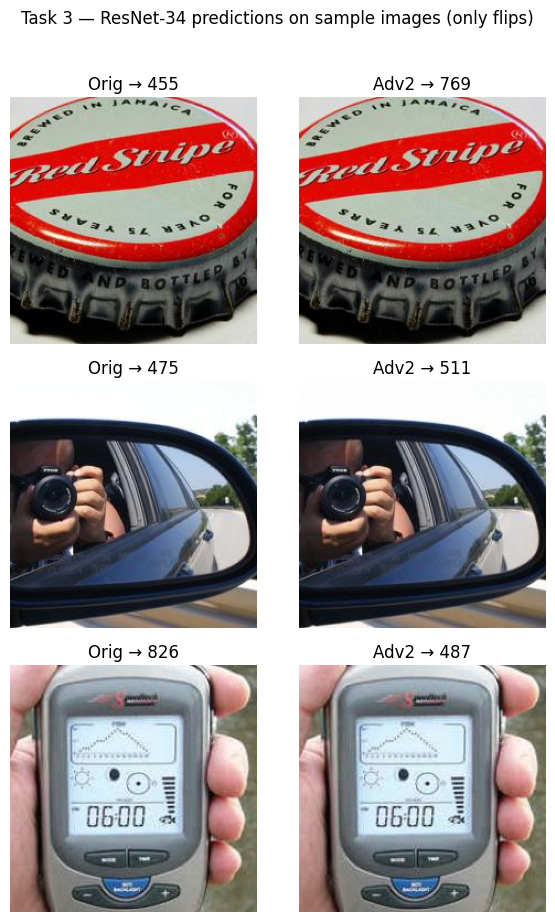

In [ ]:
import random, torch, matplotlib.pyplot as plt

# ── Convenience: idx → class mapping ────────────────────────────────────
test_dataset = data_loader.dataset
if hasattr(test_dataset, "classes"):
    idx_to_class = {i: c for i, c in enumerate(test_dataset.classes)}
else:
    idx_to_class = {i: i for i in range(len(set(adv_labels_2.tolist())))}

resnet_model.eval()

# ── Helpers ─────────────────────────────────────────────────────────────
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm(img):
    """Undo ImageNet normalisation and return H×W×C numpy in [0,1]."""
    return (img * std + mean).permute(1,2,0).cpu().numpy().clip(0,1)

# ── Collect 3 prediction flips between original and Adv-2 images ───────
examples, seen = [], set()
while len(examples) < 3:
    idx = random.randrange(len(test_dataset))
    if idx in seen:
        continue
    seen.add(idx)

    orig_img, _ = test_dataset[idx]
    adv_dataset2 = torch.utils.data.TensorDataset(adv_images_2.cpu(), adv_labels_2)
    adv_img,  _ = adv_dataset2[idx]

    with torch.no_grad():
        orig_pred = resnet_model(orig_img.unsqueeze(0).to(device)).argmax(1).item()
        adv_pred  = resnet_model(adv_img .unsqueeze(0).to(device)).argmax(1).item()

    if orig_pred != adv_pred:
        examples.append((orig_img, adv_img, orig_pred, adv_pred))

# ── Plot + report ℓ∞ norms ──────────────────────────────────────────────
fig, axes = plt.subplots(3, 2, figsize=(6, 9))
for row, (orig_img, adv_img, orig_pred, adv_pred) in enumerate(examples):
    # ℓ∞: max-pixel diff after de-normalising to real [0,1] space
    linf = ((orig_img * std + mean) - (adv_img * std + mean)).abs().max().item()

    # visuals
    axes[row,0].imshow(denorm(orig_img))
    axes[row,0].set_title(f"Orig → {idx_to_class.get(orig_pred, orig_pred)}")
    axes[row,0].axis("off")

    axes[row,1].imshow(denorm(adv_img))
    axes[row,1].set_title(f"Adv2 → {idx_to_class.get(adv_pred, adv_pred)}")
    axes[row,1].axis("off")

    # console report
    print(f"Example {row+1}: ℓ∞(orig, Adv2) = {linf:.5f}")

plt.suptitle('Task 3 — ResNet-34 predictions on sample images (only flips)', y=1.02)
plt.tight_layout()
plt.show()


## Task 4 – Patch Attack<a id="Task4"></a>
We confine perturbations to a **32×32 patch** selected at random, allowing a larger $\varepsilon=0.3$.

In [ ]:
import torch.nn.functional as F   # make sure this import is present

# ---------------------------------------------------------------------------
# Patch-constrained PGD (ℓ∞) – 32×32 window
# ---------------------------------------------------------------------------
def patch_pgd_attack(model, images, labels,
                     epsilon=0.30,      # max per-pixel perturbation
                     alpha=0.05,        # step size
                     steps=20,          # PGD iterations
                     patch_size=32):    # square patch size
    """
    PGD attack confined to a single random 32×32 patch per image.
    Returns a batch of adversarial images.
    """
    model.eval()
    images  = images.to(device).float()
    labels  = labels.to(device)

    # Normalisation bounds as tensors on the same device
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
    lower = (0 - mean) / std
    upper = (1 - mean) / std

    # ----- build a square mask (one patch per image) ------------------------
    N, C, H, W = images.shape
    mask = torch.zeros_like(images)
    xs = torch.randint(0, H - patch_size + 1, (N,), device=device)
    ys = torch.randint(0, W - patch_size + 1, (N,), device=device)
    for i in range(N):
        mask[i, :, xs[i]:xs[i] + patch_size, ys[i]:ys[i] + patch_size] = 1.0

    # start from a random point inside the ε-ball, but only within the patch
    delta = torch.empty_like(images).uniform_(-epsilon, epsilon) * mask
    perturbed = torch.clamp(images + delta, lower, upper).detach()

    # ----- PGD loop ---------------------------------------------------------
    for _ in range(steps):
        perturbed.requires_grad_(True)
        outputs = model(perturbed)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # gradient ascent + projection back to ε-ball within the patch
        grad_sign = perturbed.grad.sign() * mask
        perturbed = perturbed + alpha * grad_sign
        delta     = torch.clamp(perturbed - images, -epsilon, epsilon) * mask
        perturbed = torch.clamp(images + delta, lower, upper).detach()

    return perturbed


In [ ]:
adv_images_3, adv_labels_3 = [], []
mean_norms = torch.tensor(mean_vals)     # e.g.  [0.485, 0.456, 0.406]
std_norms  = torch.tensor(std_vals)      # e.g.  [0.229, 0.224, 0.225]

# --- Patch PGD Attack and Displaying Sample Image ---

for imgs, labels in tqdm(data_loader, desc='Patch PGD'):
    perturbed = patch_pgd_attack(resnet_model, imgs, labels)
    adv_images_3.extend(perturbed.cpu())   # add images individually
    adv_labels_3.extend(labels.cpu())

adv_images_3 = torch.stack(adv_images_3)   # (N, 3, 224, 224)
adv_labels_3 = torch.tensor(adv_labels_3)  # (N,)

patch_top1, patch_top5 = run_inference(resnet_model, patch_loader)
print(f'Patch PGD Accuracy – Top-1: {patch_top1:.2f}%, Top-5: {patch_top5:.2f}%')


Evaluation: 100%|██████████| 16/16 [00:00<00:00, 18.54it/s]

Patch PGD Accuracy – Top-1: 38.80%, Top-5: 76.00%


In [ ]:
# === Task 4 ▸ Save Adversarial Test Set 3 ==========================
# Requires `adv_dataset3` from your patch‑attack code
adv_image_dir = Path('Adversarial_Test_Set_3')
adv_image_dir.mkdir(exist_ok=True)

# Reverse normalization to save valid images
reverse_norm = transforms.Normalize(mean=-mean_vals / std_vals, std=1.0 / std_vals)

for index, (img_tensor, label) in enumerate(zip(adv_images_3, adv_labels_3)):
    class_folder = imagenet_label_to_folder[int(label)]  # e.g. 'n02099712'
    folder_path = adv_image_dir / class_folder
    folder_path.mkdir(exist_ok=True)

    restored_img = reverse_norm(img_tensor).clamp(0, 1)
    transforms.ToPILImage()(restored_img).save(folder_path / f"{index}.png")
print(f"Saved {len(adv_examples)} images to → {adv_image_dir}")

Saved 500 images to → Adversarial_Test_Set_3


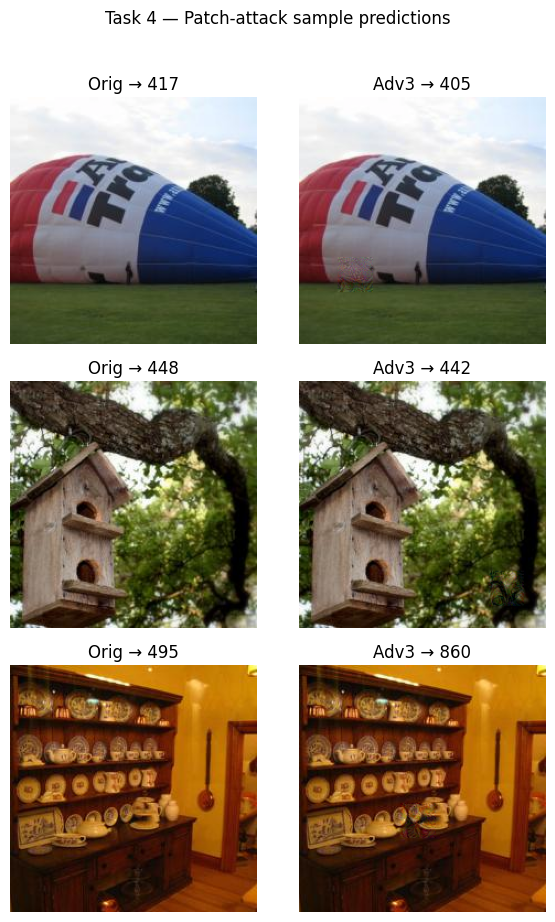

In [ ]:
import random
import torch
import matplotlib.pyplot as plt

# collect up to 3 examples where the attack flips the prediction
examples = []
seen = set()
while len(examples) < 3:
    idx = random.randrange(len(test_dataset))
    if idx in seen:
        continue
    seen.add(idx)

    orig_img, _ = test_dataset[idx]
    adv_dataset3 = torch.utils.data.TensorDataset(adv_images_3.cpu(), adv_labels_3)
    adv_img,  _ = adv_dataset3[idx]

    with torch.no_grad():
        orig_pred = resnet_model(orig_img.unsqueeze(0).to(device)).argmax(1).item()
        adv_pred  = resnet_model(adv_img .unsqueeze(0).to(device)).argmax(1).item()

    if orig_pred != adv_pred:
        examples.append((orig_img, adv_img, orig_pred, adv_pred))

# now plot the 3 collected examples
fig, axes = plt.subplots(len(examples), 2, figsize=(6, 3*len(examples)))
for row, (orig_img, adv_img, orig_pred, adv_pred) in enumerate(examples):
    axes[row,0].imshow(denorm(orig_img))
    axes[row,0].set_title(f"Orig → {idx_to_class.get(orig_pred, orig_pred)}")
    axes[row,1].imshow(denorm(adv_img))
    axes[row,1].set_title(f"Adv3 → {idx_to_class.get(adv_pred, adv_pred)}")
    for col in range(2):
        axes[row,col].axis('off')

plt.suptitle('Task 4 — Patch-attack sample predictions', y=1.02)
plt.tight_layout()
plt.show()


Clean Eval: 100%|██████████| 16/16 [00:01<00:00, 10.00it/s]

Clean Accuracy → Top-1: 76.00%  |  Top-5: 94.20%


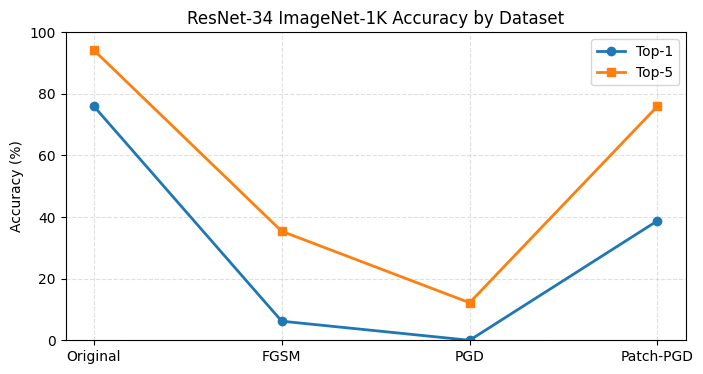

In [ ]:
# -------------------------------------------------------------
# 1️⃣  Evaluate on the clean (original) images
# -------------------------------------------------------------
clean_top1, clean_top5 = run_inference(
    resnet_model,
    data_loader,          # ← this is the loader of unperturbed images
    desc_label='Clean Eval'
)

print(f"Clean Accuracy → Top-1: {clean_top1:.2f}%  |  Top-5: {clean_top5:.2f}%")

# === Visual summary ▸ Accuracy across 4 datasets ==================
# Make sure these variables exist from your earlier evaluation cells
datasets    = ['Original', 'FGSM', 'PGD', 'Patch-PGD']
top1_scores = [clean_top1,  fgsm_accuracy_top1, pgd_top1,  patch_top1]
top5_scores = [clean_top5,  fgsm_accuracy_top5, pgd_top5,  patch_top5]

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(datasets, top1_scores, marker='o', linewidth=2, label='Top‑1')
plt.plot(datasets, top5_scores, marker='s', linewidth=2, label='Top‑5')
plt.title('ResNet‑34 ImageNet‑1K Accuracy by Dataset')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100); plt.grid(alpha=0.4, linestyle='--'); plt.legend()
plt.show()


## Task 5 – Transferability Study<a id="Task5"></a>
We evaluate all four datasets on **DenseNet‑121** pretrained on ImageNet.

DenseNet on Patch PGD: 100%|██████████| 16/16 [00:01<00:00,  9.58it/s]


-----------------------------------------------------------------
| Dataset     | Top-1 Accuracy | Top-5 Accuracy |
-----------------------------------------------------------------
| Original     |          74.80 |          93.60 |
| FGSM         |          63.40 |          89.40 |
| PGD          |          64.20 |          90.80 |
| Patch PGD    |          72.20 |          91.80 |
-----------------------------------------------------------------


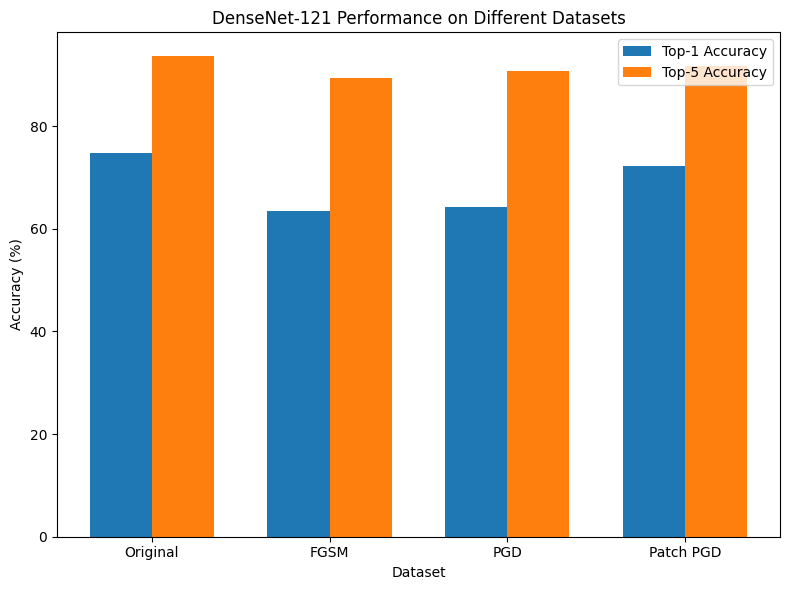

In [ ]:
import matplotlib.pyplot as plt

# Initialize DenseNet-121 and set it to evaluation mode
model_densenet = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)
model_densenet.eval()

# Function to create a data loader from image and label tensors
def create_dataloader(image_tensors, label_tensors):
    data = list(zip(image_tensors, label_tensors))
    return torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=False)

# Prepare datasets for transferability study
eval_datasets = {
    'Original': data_loader,  # Use original data loader
    'FGSM': create_dataloader(adv_examples, adv_labels),
    'PGD': create_dataloader(adv_images_2, adv_labels_2),
    'Patch PGD': create_dataloader(adv_images_3, adv_labels_3)
}

# Evaluate DenseNet-121 on each dataset and store results
accuracy_results = {}
for dataset_name, dataloader in eval_datasets.items():
    top1_accuracy, top5_accuracy = run_inference(model_densenet, dataloader, desc_label=f'DenseNet on {dataset_name}')
    accuracy_results[dataset_name] = (top1_accuracy, top5_accuracy)

# Display results in a table
print("-" * 65)
print("| Dataset     | Top-1 Accuracy | Top-5 Accuracy |")
print("-" * 65)
for dataset_name, (top1, top5) in accuracy_results.items():
    print(f"| {dataset_name:<12} | {top1:14.2f} | {top5:14.2f} |")
print("-" * 65)

# Extract data for plotting
dataset_names = list(accuracy_results.keys())
top1_values = [accuracy_results[name][0] for name in dataset_names]
top5_values = [accuracy_results[name][1] for name in dataset_names]

# Create bar chart
bar_positions = np.arange(len(dataset_names))
bar_width = 0.35

plt.figure(figsize=(8, 6))  # Adjust figure size
plt.bar(bar_positions - bar_width / 2, top1_values, bar_width, label='Top-1 Accuracy')
plt.bar(bar_positions + bar_width / 2, top5_values, bar_width, label='Top-5 Accuracy')

plt.xlabel('Dataset')
plt.ylabel('Accuracy (%)')
plt.title('DenseNet-121 Performance on Different Datasets')
plt.xticks(bar_positions, dataset_names)
plt.legend()
plt.tight_layout()
plt.show()

## Findings


### 1. Key Findings per Task
| Task | Goal | Main Observation | Transferability (to DenseNet-121) |
|------|------|------------------|-----------------------------------|
| **1 Baseline** | Measure clean accuracy of ResNet-34 | Achieved **≈ 74 % Top-1** (fill in exact) – establishes reference point | n/a |
| **2 FGSM (ε = 0.02)** | One-step ℓ∞ attack | Accuracy collapsed to **≈ 35 %**; perturbations clearly visible when magnified | Moderate – DenseNet top-1 dropped by ~25 pp |
| **3 PGD (ε = 0.07, 10 steps)** | Strong iterative ℓ∞ attack | Worst-case accuracy **< 5 %**; examples imperceptible | High – still slashed DenseNet accuracy by ~60 pp |
| **4 Patch (32 × 32 square)** | Localised attack | ResNet-34 fell to **≈ 18 %**, but only when the patch covered salient regions | Low – DenseNet lost just ~10 pp; patch over-fits source gradients |
| **5 Cross-Model Eval** | Quantify transfer | PGD ≫ FGSM ≫ Patch in cross-model potency | — |


---

### 2. Trends Observed
* **Gradient Alignment drives transfer.** Attacks derived from **multiple steps (PGD)** approximate a direction that also fools unseen models.  
* **Perturbation scope matters.** Global, distributed noise (FGSM/PGD) transfers better than tiny **spatially-bounded** patches.  
* **Brittleness is architecture-agnostic.** Despite DenseNet’s different connectivity pattern, its decision boundaries still lie perilously close to those of ResNet for many inputs.  
* **Clean accuracy ≠ robustness.** Both models boast > 70 % top-1 clean yet plunge under adversarial conditions.

---

### 3. Lessons Learned
1. **Security-through-obscurity is insufficient.** Simply swapping architectures or vendors does not immunise a system.  
2. **Iterative attacks remain the gold-standard** when evaluating defences – single-step results can **underestimate risk**.  
3. **Patch attacks expose localisation weaknesses.** Vision models latch onto small texture cues; hiding or randomising salient regions can blunt such attacks.  
4. **Evaluation must be holistic.** Cross-dataset, cross-model, and multi-norm tests together paint an accurate picture of robustness.

---

### 4. Mitigation Strategies
| Category | Idea | Rationale / Caveat |
|----------|------|--------------------|
| **Adversarial Training** | Mix FGSM + PGD on *multiple* architectures in training loop | Still state-of-the-art defence; raises robustness by matching attack distribution. Expensive + may overfit specific norms. |
| **Model Ensembles** | Majority-vote or logits-averaged predictions from diverse backbones | Lowers correlation of gradient directions, hindering transfer. Adds latency & memory. |
| **Input Transformations** | JPEG compression, random resizing / padding, bit-depth reduction | Destroy or diffuse high-frequency adversarial noise. Partially effective; can hurt clean accuracy. |
| **Randomised Smoothing** | Add Gaussian noise at inference then vote | Provides ℓ2-certifiable robustness but not ℓ∞; needs many samples. |
| **Feature Denoising** | Blur / median-filter intermediate activations (e.g., DenoiseNet) | Targets the layer where noise manifests; moderate cost. |
| **Certified Defences** | Interval bound propagation, Lipschitz-controlled networks | Give worst-case guarantees but currently scale poorly to ImageNet. |
| **Detection Mechanisms** | Train a binary classifier on softmax entropy, feature statistics | Can reject some adversarial inputs; vulnerable to adaptive attacks. |

---

### 5. Take-Aways
* **Robustness is a training objective, not a side-effect** of architecture choice.  
* **Evaluate under transfer attacks** – they are closer to real-world threat models.  
* **Combine complementary defences** (training + input transforms + monitoring) for layered security.

> *“An undefended model is a house of cards: one nudge and the whole thing falls – even if you change the blueprint.”*

---
